In [1]:
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from tensorflow.keras.optimizers import Adam, Adadelta, Adagrad, Adamax, Ftrl, Nadam, RMSprop
from tensorflow.keras.losses import categorical_crossentropy, MeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, concatenate, Input, Conv2D, MaxPooling2D
from tensorflow.keras.layers import LeakyReLU

In [2]:
train_dir = 'Potongan/train'
test_dir = 'Potongan/test'
hiragana_train_dir = train_dir + "/Hiragana"
katakana_train_dir = train_dir + "/Katakana"
hiragana_test_dir = test_dir + "/Hiragana"
katakana_test_dir = test_dir + "/Katakana"
sample_submission = pd.read_csv('sample_submission.csv')

In [3]:
letter_labels = [
    [0, "A", "A"], [1, "Ba", "Ba"], [2, "Be", "Be"], [3, "Bi", "Bi"], [4, "Bo", "Bo"], [5, "Bu", "Bu"],
    [6, "Bya", "Bya"], [7, "Byo", "Byo"], [8, "Byu", "Byu"], [9, "Cha", "Cha"], [10, "Chi", "Chi"],
    [11, "Cho", "Cho"], [12, "Chu", "Chu"], [13, "Da", "Da"], [14, "De", "De"], [15, "Do", "Do"],
    [16, "E", "E"], [17, "Fu", "Fu"], [18, "Ga", "Ga"], [19, "Ge", "Ge"], [20, "Gi", "Gi"],
    [21, "Go", "Go"], [22, "Gu", "Gu"], [23, "Gya", "Gya"], [24, "Gyo", "Gyo"], [25, "Gyu", "Gyu"],
    [26, "Ha", "Ha"], [27, "He", "He"], [28, "Hi", "Hi"], [29, "Ho", "Ho"], [30, "Hya", "Hya"],
    [31, "Hyo", "Hyo"], [32, "Hyu", "Hyu"], [33, "I", "I"], [34, "Ja", "Ja"], [35, "Ji", "Ji"],
    [36, "Ji_2", "Ji"], [37, "Jo", "Jo"], [38, "Ju", "Ju"], [39, "Ka", "Ka"], [40, "Ke", "Ke"],
    [41, "Ki", "Ki"], [42, "Ko", "Ko"], [43, "Ku", "Ku"], [44, "Kya", "Kya"], [45, "Kyo", "Kyo"],
    [46, "Kyu", "Kyu"], [47, "Ma", "Ma"], [48, "Me", "Me"], [49, "Mi", "Mi"], [50, "Mo", "Mo"],
    [51, "Mu", "Mu"], [52, "Mya", "Mya"], [53, "Myo", "Myo"], [54, "Myu", "Myu"], [55, "N", "N"],
    [56, "Na", "Na"], [57, "Ne", "Ne"], [58, "Ni", "Ni"], [59, "No", "No"], [60, "Nu", "Nu"],
    [61, "Nya", "Nya"], [62, "Nyo", "Nyo"], [63, "Nyu", "Nyu"], [64, "O", "O"], [65, "Pa", "Pa"],
    [66, "Pe", "Pe"], [67, "Pi", "Pi"], [68, "Po", "Po"], [69, "Pu", "Pu"], [70, "Pya", "Pya"],
    [71, "Pyo", "Pyo"], [72, "Pyu", "Pyu"], [73, "Ra", "Ra"], [74, "Re", "Re"], [75, "Ri", "Ri"],
    [76, "Ro", "Ro"], [77, "Ru", "Ru"], [78, "Rya", "Rya"], [79, "Ryo", "Ryo"], [80, "Ryu", "Ryu"],
    [81, "Sa", "Sa"], [82, "Se", "Se"], [83, "Sha", "Sha"], [84, "Shi", "Shi"], [85, "Sho", "Sho"],
    [86, "Shu", "Shu"], [87, "So", "So"], [88, "Su", "Su"], [89, "Ta", "Ta"], [90, "Te", "Te"],
    [91, "To", "To"], [92, "Tsu", "Tsu"], [93, "U", "U"], [94, "Wa", "Wa"], [95, "Wo", "Wo"],
    [96, "Ya", "Ya"], [97, "Yo", "Yo"], [98, "Yu", "Yu"], [99, "Za", "Za"], [100, "Ze", "Ze"],
    [101, "Zo", "Zo"], [102, "Zu", "Zu"], [103, "Zu_2", "Zu"], [104, "A", "A"], [105, "Ba", "Ba"],
    [106, "Be", "Be"], [107, "Bi", "Bi"], [108, "Bo", "Bo"], [109, "Bu", "Bu"], [110, "Bya", "Bya"],
    [111, "Byo", "Byo"], [112, "Byu", "Byu"], [113, "Cha", "Cha"], [114, "Che", "Che"], [115, "Chi", "Chi"],
    [116, "Cho", "Cho"], [117, "Chu", "Chu"], [118, "Da", "Da"], [119, "De", "De"], [120, "Di", "Di"],
    [121, "Do", "Do"], [122, "Du", "Du"], [123, "Dyu", "Dyu"], [124, "E", "E"], [125, "Fa", "Fa"],
    [126, "Fe", "Fe"], [127, "Fi", "Fi"], [128, "Fo", "Fo"], [129, "Fu", "Fu"], [130, "Ga", "Ga"],
    [131, "Ge", "Ge"], [132, "Gi", "Gi"], [133, "Go", "Go"], [134, "Gu", "Gu"], [135, "Gya", "Gya"],
    [136, "Gyo", "Gyo"], [137, "Gyu", "Gyu"], [138, "Ha", "Ha"], [139, "He", "He"], [140, "Hi", "Hi"],
    [141, "Ho", "Ho"], [142, "Hya", "Hya"], [143, "Hyo", "Hyo"], [144, "Hyu", "Hyu"], [145, "I", "I"],
    [146, "Ja", "Ja"], [147, "Je", "Je"], [148, "Ji", "Ji"], [149, "Ji_2", "Ji"], [150, "Jo", "Jo"],
    [151, "Ju", "Ju"], [152, "Ka", "Ka"], [153, "Ke", "Ke"], [154, "Ki", "Ki"], [155, "Ko", "Ko"],
    [156, "Ku", "Ku"], [157, "Kya", "Kya"], [158, "Kyo", "Kyo"], [159, "Kyu", "Kyu"], [160, "Ma", "Ma"],
    [161, "Me", "Me"], [162, "Mi", "Mi"], [163, "Mo", "Mo"], [164, "Mu", "Mu"], [165, "Mya", "Mya"],
    [166, "Myo", "Myo"], [167, "Myu", "Myu"], [168, "N", "N"], [169, "Na", "Na"], [170, "Ne", "Ne"],
    [171, "Ni", "Ni"], [172, "No", "No"], [173, "Nu", "Nu"], [174, "Nya", "Nya"], [175, "Nyo", "Nyo"],
    [176, "Nyu", "Nyu"], [177, "O", "O"], [178, "Pa", "Pa"], [179, "Pe", "Pe"], [180, "Pi", "Pi"],
    [181, "Po", "Po"], [182, "Pu", "Pu"], [183, "Pya", "Pya"], [184, "Pyo", "Pyo"], [185, "Pyu", "Pyu"],
    [186, "Ra", "Ra"], [187, "Re", "Re"], [188, "Ri", "Ri"], [189, "Ro", "Ro"], [190, "Ru", "Ru"],
    [191, "Rya", "Rya"], [192, "Ryo", "Ryo"], [193, "Ryu", "Ryu"], [194, "Sa", "Sa"], [195, "Se", "Se"],
    [196, "Sha", "Sha"], [197, "She", "She"], [198, "Shi", "Shi"], [199, "Sho", "Sho"], [200, "Shu", "Shu"],
    [201, "So", "So"], [202, "Su", "Su"], [203, "Ta", "Ta"], [204, "Te", "Te"], [205, "Ti", "Ti"],
    [206, "To", "To"], [207, "Tsa", "Tsa"], [208, "Tse", "Tse"], [209, "Tso", "Tso"], [210, "Tsu", "Tsu"],
    [211, "Tu", "Tu"], [212, "U", "U"], [213, "Wa", "Wa"], [214, "We", "We"], [215, "Wi", "Wi"],
    [216, "Wo", "Wo"], [217, "Wo_2", "Wo"], [218, "Ya", "Ya"], [219, "Yo", "Yo"], [220, "Yu", "Yu"],
    [221, "Za", "Za"], [222, "Ze", "Ze"], [223, "Zo", "Zo"], [224, "Zu", "Zu"], [225, "Zu_2", "Zu"]
]

In [4]:
def input_data(data, k_dir, h_dir):
    for label_num, label in enumerate(letter_labels):
        if label[0] >= 104:
            for file in os.listdir(os.path.join(k_dir, "Katakana_"+label[1])):
                data.append(['{}/{}/{}'.format(k_dir,
                                                "Katakana_"+label[1],
                                                file),
                                label_num, label[1]])
        else :
            for file in os.listdir(os.path.join(h_dir, "Hiragana_"+label[1])):
                data.append(['{}/{}/{}'.format(h_dir,
                                                "Hiragana_"+label[1],
                                                file),
                                label_num, label[1]])
    return data

In [5]:
train = []

train = input_data(train, katakana_train_dir, hiragana_train_dir)

train = pd.DataFrame(train, columns=['file', 'label_num', 'english_word'])

print('Training Data: ',train.shape)
print(train.head(5))

Training Data:  (10393, 3)
                                            file  label_num english_word
0   Potongan/train/Hiragana/Hiragana_A/1 a 1.jpg          0            A
1   Potongan/train/Hiragana/Hiragana_A/1 a 2.jpg          0            A
2  Potongan/train/Hiragana/Hiragana_A/10 a 1.jpg          0            A
3  Potongan/train/Hiragana/Hiragana_A/10 a 2.jpg          0            A
4  Potongan/train/Hiragana/Hiragana_A/11 a 1.jpg          0            A


In [6]:
x_train = []

for i in range(len(train)):
    file_name = format(train['file'][i])
    img = cv2.imread(file_name)
#     img_resize = cv2.resize(img,dsize=(63,63))
#     img_resize = cv2.resize(img,dsize=(66,66))
    img_resize = cv2.resize(img,dsize=(69,69))
#     img_resize = cv2.resize(img,dsize=(72,72))
    grayImage = cv2.bitwise_not(cv2.cvtColor(img_resize,
                                             cv2.COLOR_BGR2GRAY))
    (thresh, blackAndWhiteImage) = cv2.threshold(grayImage,
                                                 127, 1,
                                                 cv2.THRESH_BINARY)
#     img_open = cv2.morphologyEx(blackAndWhiteImage, cv2.MORPH_OPEN, kernel=np.ones((3, 3), np.uint8))
    img_dilation = cv2.dilate(blackAndWhiteImage,
                              np.ones((3, 3), np.uint8),
                              iterations=1)
    img_erotion = cv2.erode(img_dilation,
                            np.ones((3, 3), np.uint8),
                            iterations=2)
#     img_stack = np.reshape(img_erotion,(63,63,1))
#     img_stack = np.reshape(img_erotion,(66,66,1))
    img_stack = np.reshape(img_erotion,(69,69,1))
#     img_stack = np.reshape(img_erotion,(72,72,1))
    x_train.append(np.concatenate((np.array(img_resize),
                                   np.array(img_stack)), axis=2))

x_train = np.array(x_train)

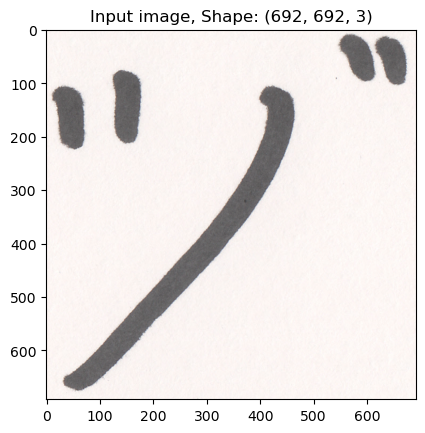

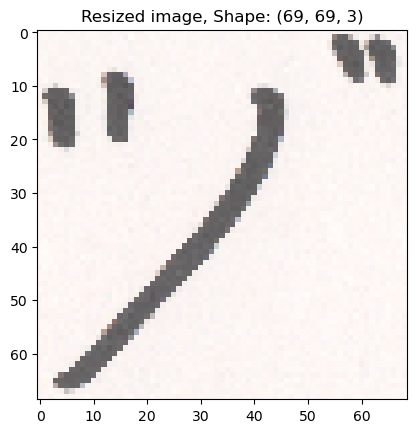

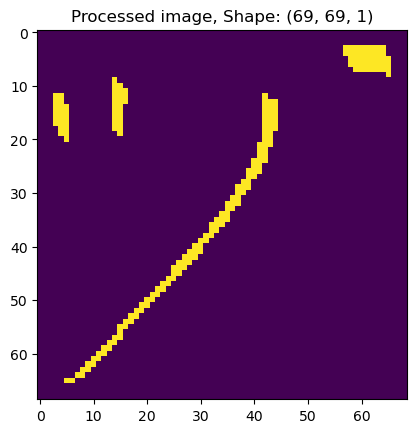

In [7]:
Input_image = cv2.imread(train['file'][len(train)-1])

plt.imshow(Input_image)
plt.title('Input image, Shape: '+str(Input_image.shape))
plt.show()

plt.imshow(img_resize)
plt.title('Resized image, Shape: '+str(img_resize.shape))
plt.show()

# plt.imshow(np.reshape(img_stack,(63,63)))
# plt.imshow(np.reshape(img_stack,(66,66)))
plt.imshow(np.reshape(img_stack,(69,69)))
# plt.imshow(np.reshape(img_stack,(72,72)))
plt.title('Processed image, Shape: '+str(img_stack.shape))
plt.show()

In [8]:
labels = train['label_num']
labels = to_categorical(labels, num_classes = len(letter_labels))

In [9]:
x_train, x_val, y_train, y_val = train_test_split(x_train,
                                                  labels,
                                                  test_size = 0.1)

In [10]:
input_shape = x_train[1].shape
print('Input Shape is :', input_shape)

Input Shape is : (69, 69, 4)


In [11]:
test = []

test = input_data(test, katakana_test_dir, hiragana_test_dir)

test = pd.DataFrame(test, columns=['file', 'label_num', 'english_word'])
print(test.head(5))

                                           file  label_num english_word
0   Potongan/test/Hiragana/Hiragana_A/1 a 3.jpg          0            A
1  Potongan/test/Hiragana/Hiragana_A/10 a 3.jpg          0            A
2  Potongan/test/Hiragana/Hiragana_A/11 a 3.jpg          0            A
3  Potongan/test/Hiragana/Hiragana_A/12 a 3.jpg          0            A
4  Potongan/test/Hiragana/Hiragana_A/13 a 3.jpg          0            A


In [12]:
x_test = []

for i in range(len(test)):
    img = cv2.imread(test['file'][i])
#     img_resize = cv2.resize(img,dsize=(63,63))
#     img_resize = cv2.resize(img,dsize=(66,66))
    img_resize = cv2.resize(img,dsize=(69,69))
#     img_resize = cv2.resize(img,dsize=(72,72))
    grayImage = cv2.bitwise_not(cv2.cvtColor(img_resize,
                                             cv2.COLOR_BGR2GRAY))
    (thresh, blackAndWhiteImage) = cv2.threshold(grayImage,
                                                 127, 1,
                                                 cv2.THRESH_BINARY)
    img_dilation = cv2.dilate(blackAndWhiteImage,
                              np.ones((3, 3), np.uint8),
                              iterations=1)
    img_erotion = cv2.erode(img_dilation,
                            np.ones((3, 3), np.uint8),
                            iterations=2)
#     img_stack = np.reshape(img_erotion,(63,63,1))
#     img_stack = np.reshape(img_erotion,(66,66,1))
    img_stack = np.reshape(img_erotion,(69,69,1))
#     img_stack = np.reshape(img_erotion,(72,72,1))
    x_test.append(np.concatenate((np.array(img_resize),
                                  np.array(img_stack)), axis=2))

x_test = np.array(x_test)

In [13]:
y_test = test['label_num']
y_test = to_categorical(y_test, num_classes = len(letter_labels))

In [14]:
test_shape = x_test[1].shape
print('Test Shape is :', test_shape)

Test Shape is : (69, 69, 4)


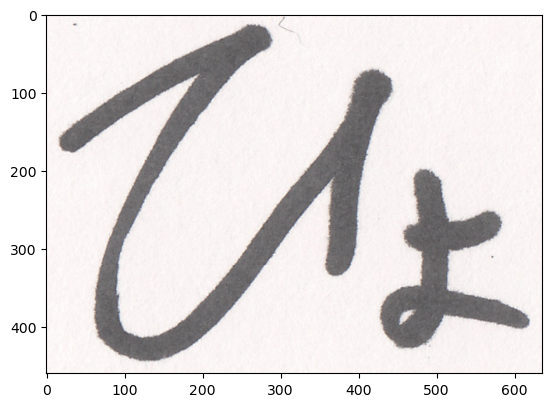

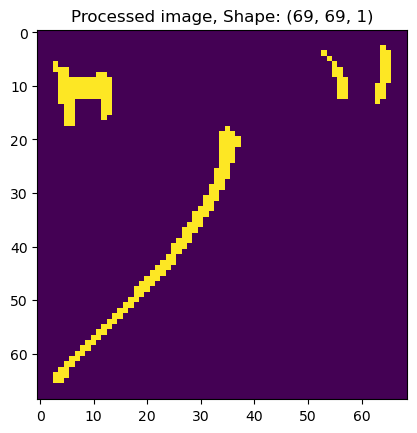

In [15]:
randm = np.random.randint(0,len(test))

img = cv2.imread(test['file'][randm])
plt.imshow(img)
plt.show()

plt.imshow(np.reshape(img_stack,(69,69)))

plt.title('Processed image, Shape: '+str(img_stack.shape))
plt.show()

In [16]:
def fire_incepter(x, fire=16, intercept=64):
    x = Conv2D(fire, (5,5), strides=(2,2))(x)
    x = LeakyReLU(alpha=0.15)(x)

    left = Conv2D(intercept, (3,3), padding='same')(x)
    left = LeakyReLU(alpha=0.15)(left)

    right = Conv2D(intercept, (5,5), padding='same')(x)
    right = LeakyReLU(alpha=0.15)(right)

    x = concatenate([left, right], axis=3)
    x = MaxPooling2D(strides=2, pool_size=3)(x)
    return x

def fire_squeezer(x, fire=16, intercept=64):
    x = Conv2D(fire, (1,1))(x)
    x = LeakyReLU(alpha=0.15)(x)

    left = Conv2D(intercept, (1,1))(x)
    left = LeakyReLU(alpha=0.15)(left)

    right = Conv2D(intercept, (3,3), padding='same')(x)
    right = LeakyReLU(alpha=0.15)(right)

    x = concatenate([left, right], axis=3)
    x = MaxPooling2D(strides=2, pool_size=2)(x)
    return x

image_input=Input(shape=input_shape)

x = fire_incepter(image_input, fire=16, intercept=16)

x = fire_squeezer(x, fire=64, intercept=64)

x = fire_squeezer(x, fire=64, intercept=64)

x = Conv2D(64, (2,2))(x)
x = LeakyReLU(alpha=0.1)(x)

x = Flatten()(x)

x = Dense(512)(x)
x = LeakyReLU(alpha=0.1)(x)
x = Dropout(0.1)(x)

out = Dense(len(letter_labels), activation='softmax')(x)

model_new = Model(image_input, out)
model_new.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 69, 69, 4)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 33, 33, 16)   1616        ['input_1[0][0]']                
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 33, 33, 16)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 33, 33, 16)   2320        ['leaky_re_lu[0][0]']            
                                                                                              

In [17]:
model_new.compile(optimizer = Nadam(learning_rate=0.001) ,
                  loss = 'categorical_crossentropy',
                  metrics=['accuracy'])

epochs = 30

history = model_new.fit(x=x_train, y=y_train, validation_data=(x_val, y_val),
                        batch_size = 32, epochs=epochs,
                        callbacks=[EarlyStopping(monitor='val_loss',
#                         callbacks=[EarlyStopping(monitor='val_accuracy',
                                    patience=3,
#                                     patience=0,
                                    mode='auto')]
             )

Epoch 1/30
293/293 [==============================] - 93s 289ms/step - loss: 3.4764 - accuracy: 0.3033 - val_loss: 2.1807 - val_accuracy: 0.4663
Epoch 2/30
293/293 [==============================] - 88s 301ms/step - loss: 0.9046 - accuracy: 0.7319 - val_loss: 0.7644 - val_accuracy: 0.7798
Epoch 3/30
293/293 [==============================] - 85s 290ms/step - loss: 0.4596 - accuracy: 0.8526 - val_loss: 0.6436 - val_accuracy: 0.8173
Epoch 4/30
293/293 [==============================] - 74s 254ms/step - loss: 0.3075 - accuracy: 0.9022 - val_loss: 0.5869 - val_accuracy: 0.8385
Epoch 5/30
293/293 [==============================] - 93s 319ms/step - loss: 0.2321 - accuracy: 0.9221 - val_loss: 0.6081 - val_accuracy: 0.8337
Epoch 6/30
293/293 [==============================] - 81s 276ms/step - loss: 0.1936 - accuracy: 0.9396 - val_loss: 0.5743 - val_accuracy: 0.8625
Epoch 7/30
293/293 [==============================] - 77s 262ms/step - loss: 0.1956 - accuracy: 0.9356 - val_loss: 0.5592 - val_ac

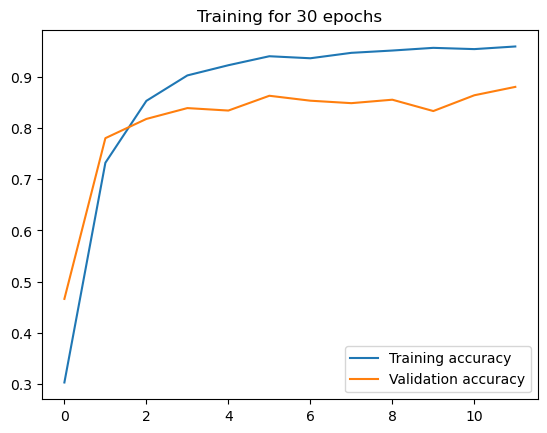

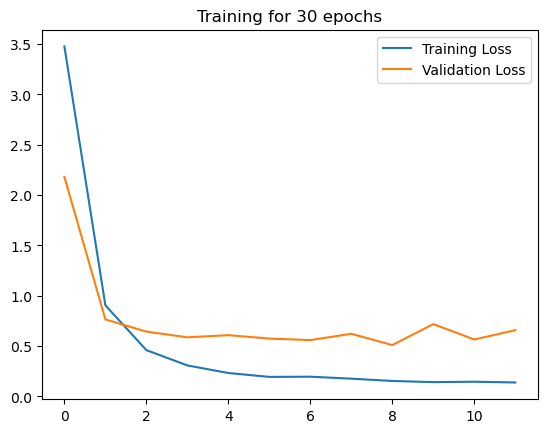

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training for ' +str(epochs)+ ' epochs')
plt.legend(['Training accuracy', 'Validation accuracy'], loc='lower right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training for ' +str(epochs)+ ' epochs')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.show()

In [19]:
score = model_new.evaluate(x_val,y_val)
print('Accuracy on Validation Set', round(score[1],4))

33/33 [==============================] - 2s 69ms/step - loss: 0.6576 - accuracy: 0.8798
Accuracy on Validation Set 0.8798


In [20]:
Pred_labels = np.argmax(model_new.predict(x_test),axis = 1)

Pred_labels = pd.DataFrame(Pred_labels,index =None,columns=['label_num'])

test_df = pd.DataFrame()
test_df['label_num'] = Pred_labels['label_num']
test_df['file'] = test['file']
test_df['english_word'] = [letter_labels[i][2] for i in Pred_labels['label_num']]

submission = pd.merge(left=sample_submission, right=test_df[['file',
                                                             'english_word']],
                      on="file", how="right")
submission.drop(['english_word_x'], axis = 1, inplace = True)
submission.columns = ['file','english_word']

submission.to_csv('submission.csv', index=False)
print(submission.head())

print('')
print('Data test Accuracy : ', round(accuracy_score(np.argmax(y_test, axis=1), Pred_labels),4))

163/163 [==============================] - 11s 65ms/step
                                           file english_word
0   Potongan/test/Hiragana/Hiragana_A/1 a 3.jpg            A
1  Potongan/test/Hiragana/Hiragana_A/10 a 3.jpg            A
2  Potongan/test/Hiragana/Hiragana_A/11 a 3.jpg            A
3  Potongan/test/Hiragana/Hiragana_A/12 a 3.jpg            A
4  Potongan/test/Hiragana/Hiragana_A/13 a 3.jpg            A

Data test Accuracy :  0.8759
